In [1]:
pip install pybbn

  Preparing metadata (setup.py) ... done
  Created wheel for pybbn: filename=pybbn-3.2.3-py3-none-any.whl size=40372 sha256=910f50a99b82288e3e9f4bbfa64b9e5a6ec9c9f4ddd39d99595060f64cf8ca39
  Stored in directory: /root/.cache/pip/wheels/07/00/f6/a1ad0aa73a832ed29ae62a32a5bd05a911596be0d8d7cc7ad6
Successfully built pybbn


       Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0        Albury     13.4     22.9       0.6     5.341124    7.3921   
1        Albury      7.4     25.1       0.0     5.341124    7.3921   
2        Albury     12.9     25.7       0.0     5.341124    7.3921   
3        Albury      9.2     28.0       0.0     5.341124    7.3921   
4        Albury     17.5     32.3       1.0     5.341124    7.3921   
...         ...      ...      ...       ...          ...       ...   
108152  Woomera      8.7     25.3       0.0     6.800000   10.5000   
108153  Woomera      9.0     23.1       0.0     7.000000    9.9000   
108154  Woomera     10.0     27.1       0.0     4.000000    8.4000   
108155  Woomera     12.8     30.1       0.0     7.200000    7.7000   
108156  Woomera     17.5     21.1       1.0     9.400000    0.5000   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0                W           44.0          W        WNW          20.0   
1            

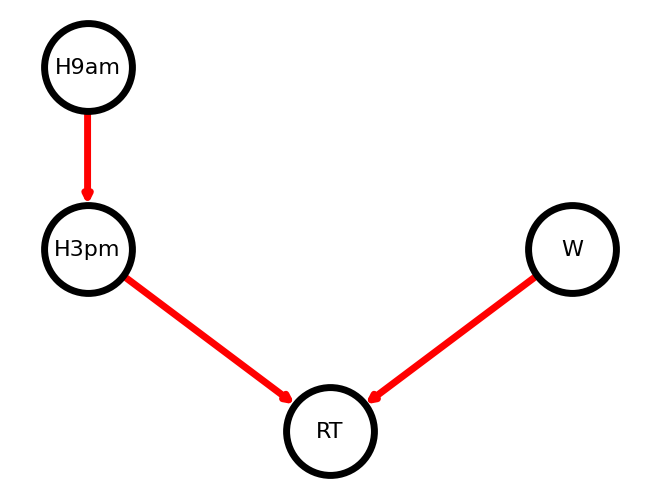

In [2]:
import pandas as pd # for data manipulation
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
#Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv('/content/weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]
# Drop the 'Date' column as it is not relevant for the model
df = df.drop(columns='Date')

# For other columns with missing values, fill them in with column mean for numeric columns only
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Create bands for variables that we want to use in the model
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else
                                                            '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

# Show a snaphsot of data
print(df)

# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob
# Create nodes by using our earlier function to automatically calculate probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

# Create Network
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}

# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()
